# z5206762 MTRN4110 Phase C

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

## Task 1:

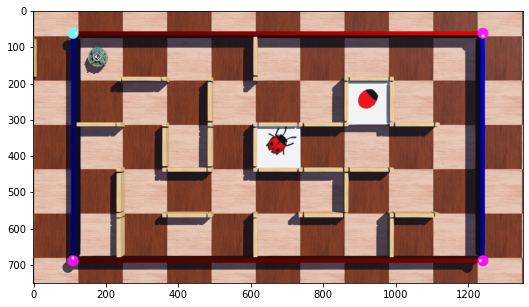

In [550]:
# Read in maze, robot and ladybug image from upper folder, and create or open the map text file
map_location = '../Maze.png'
map_image = cv2.imread(map_location)
robot_location = '../Robot.png'
robot_image = cv2.imread(robot_location)
bug_location = '../Ladybug_small.png'
bug_image = cv2.imread(bug_location)
textmap_location = '../MapBuilt.txt'
map_built = open(textmap_location,"w")

# Convert to RGB image
map_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
robot_rgb = cv2.cvtColor(robot_image, cv2.COLOR_BGR2RGB)
bug_rgb = cv2.cvtColor(bug_image, cv2.COLOR_BGR2RGB)
plot.figure(figsize = (9,5))
plot.imshow(map_rgb)

## Task 2:

(<matplotlib.image.AxesImage at 0x202c9583b08>, Text(0.5, 1.0, 'Pink Mask'))

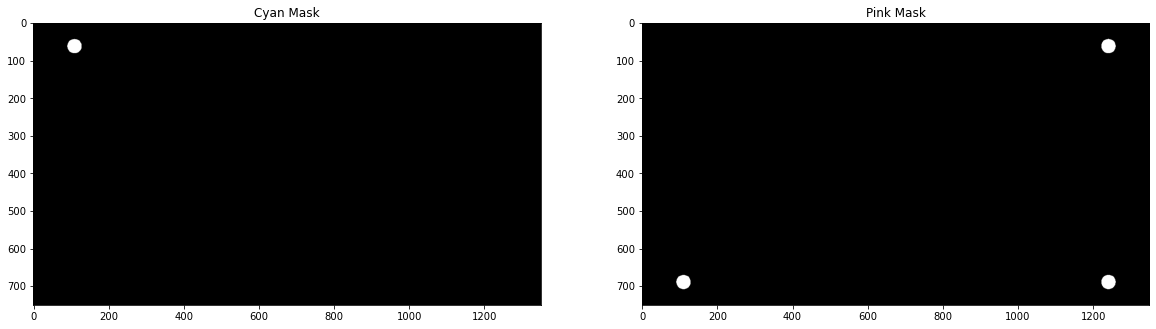

In [551]:
# Convert maze to HSV to best extract corner points, and apply an image mask to extract features
map_hsv = cv2.cvtColor(map_rgb, cv2.COLOR_RGB2HSV)
cyan = cv2.inRange(map_hsv, (87, 100, 220), (93, 150,255))
cmask = cv2.bitwise_and(map_rgb,map_rgb, mask=cyan)
pink = cv2.inRange(map_hsv, (147, 150, 220), (153, 255,255))
pmask = cv2.bitwise_and(map_rgb,map_rgb, mask=pink)

kernelx = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
pmask = cv2.dilate(pmask, kernelx)
pmask = cv2.cvtColor(pmask, cv2.COLOR_RGB2GRAY)
pmask = cv2.threshold(pmask, 100, 255, cv2.THRESH_BINARY)[1]
cmask = cv2.dilate(cmask, kernelx)
cmask = cv2.cvtColor(cmask, cv2.COLOR_RGB2GRAY)
cmask = cv2.threshold(cmask, 100, 255, cv2.THRESH_BINARY)[1]

# A mask for the cyan and pink corners
fig, (cplot, pplot) = plot.subplots(figsize = (20,10), ncols = 2)
cplot.imshow(cmask, cmap = 'gray'), cplot.set_title("Cyan Mask")
pplot.imshow(pmask, cmap = 'gray'), pplot.set_title("Pink Mask")

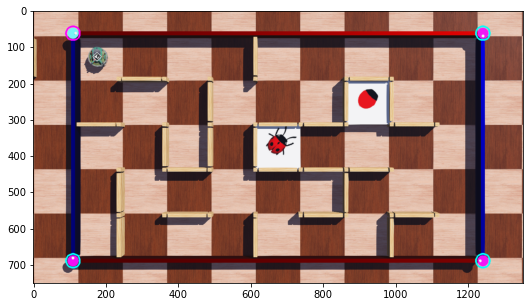

In [552]:
# Extract edges and contours from each mask
cedges = cv2.Canny(cmask, threshold1 = 100, threshold2 = 200, apertureSize = 3)
pedges = cv2.Canny(pmask, threshold1 = 100, threshold2 = 200, apertureSize = 3)
new_image, ccontours, hierarchy = cv2.findContours(cedges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
new_image, pcontours, hierarchy = cv2.findContours(pedges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw in the associated contours in magenta/cyan
cv2.drawContours(map_image, ccontours, -1, (255,0,255), 3)
cv2.drawContours(map_image, pcontours, -1, (255,255,0), 3)
img_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
plot.figure(figsize = (9,5))
plot.imshow(img_rgb)

## Task 3:

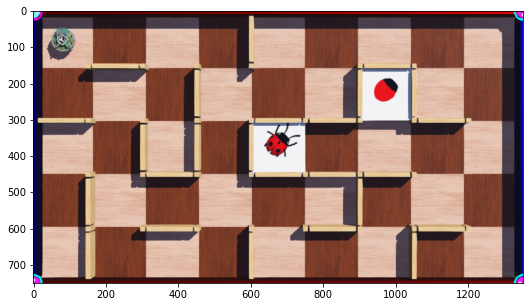

In [553]:
# Find centre of each circle drawn previously from moment of contour
cnt = ccontours[0]
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
px = []
py = []
for i, cnt in enumerate(pcontours):
    M = cv2.moments(cnt)
    px.append(int(M['m10']/M['m00']))
    py.append(int(M['m01']/M['m00']))

# Establish points for transform
order = [0,1,2]
if cx < 338:
    for i in range(0, 3):
        if px[i] > 1012:
            if py[i] < 375:
                order[0] = i
            else:
                order[2] = i
        else:
            order[1] = i
else:
    for i in range(0, 3):
        if px[i] < 338:
            if py[i] < 375:
                order[1] = i
            else:
                order[0] = i
        else:
            order[2] = i
px = [px[i] for i in order]
py = [py[i] for i in order]

# Allocate points depending on map orientation and 
if cx < 338:
    p_original = np.float32([[cx,cy], [px[0],py[0]], [px[1], py[1]], [px[2], py[2]]])
    p_transform = np.float32([[0,0], [1350, 0], [0, 750], [1350, 750]])
    h = cv2.getPerspectiveTransform(p_original, p_transform)
    r0 = np.float32([[int(cx/2),cy], [int(px[0]/2),py[0]], [int(px[1]/2), py[1]], [int(px[2]/2), py[2]]])
    rr = np.float32([[200,200], [400,200], [200, 400], [400, 400]])
    hr = cv2.getPerspectiveTransform(r0, rr)
    maze_transformed = cv2.warpPerspective(img_rgb, h, (1350,750))
    robot_transformed = cv2.warpPerspective(robot_rgb, hr, (750,750))
    plot.figure(figsize = (9,5))
    plot.imshow(maze_transformed)
else:
    p_original = np.float32([[cx,cy], [px[0],py[0]], [px[1], py[1]], [px[2], py[2]]])
    p_transform = np.float32([[1350,750], [0,750], [0, 0], [1350, 0]])
    r0 = np.float32([[int(cx/2),cy], [int(px[0]/2),py[0]], [int(px[1]/2), py[1]], [int(px[2]/2), py[2]]])
    rr = np.float32([[400,400], [200,400], [200, 200], [400, 200]])
    hr = cv2.getPerspectiveTransform(r0, rr)
# Transform points
    h = cv2.getPerspectiveTransform(p_original, p_transform)
    maze_transformed = cv2.warpPerspective(img_rgb, h, (1350,750))
    maze_transformed = cv2.rotate(maze_transformed, cv2.ROTATE_180)
    robot_transformed = cv2.warpPerspective(robot_rgb, hr, (750,750))
    robot_transformed = cv2.rotate(robot_transformed, cv2.ROTATE_180)
    plot.figure(figsize = (9,5))
    plot.imshow(maze_transformed)

## Task 4:

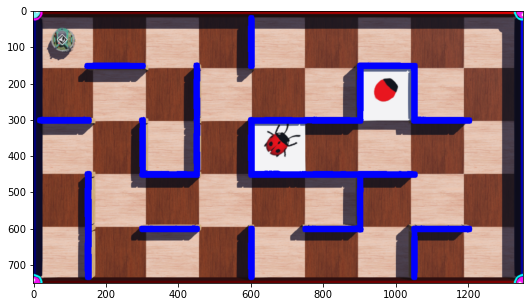

In [554]:
# Extract walls as a mask
mazet_hsv = cv2.cvtColor(maze_transformed, cv2.COLOR_RGB2HSV)
walls = cv2.inRange(mazet_hsv, (18, 50, 220), (20, 150,240))
mazegrey = cv2.cvtColor(maze_transformed, cv2.COLOR_RGB2GRAY)
wallmask = cv2.bitwise_and(mazegrey,mazegrey, mask=walls)
kernel = np.ones((3, 3), np.uint8)
wallmask = cv2.dilate(wallmask, kernel, iterations = 5)
wallmask = cv2.erode(wallmask, kernel, iterations = 7)
walledge = cv2.Canny(wallmask, threshold1 = 50, threshold2 = 100, apertureSize = 3)

# Draw out the walls by finding the wall edges
_, wcontours, hierarchy = cv2.findContours(walledge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(maze_transformed, wcontours, -1, (0,0,255), 10)
plot.figure(figsize = (9,5))
plot.imshow(maze_transformed)
new_maze = maze_transformed.copy()

## Task 5:

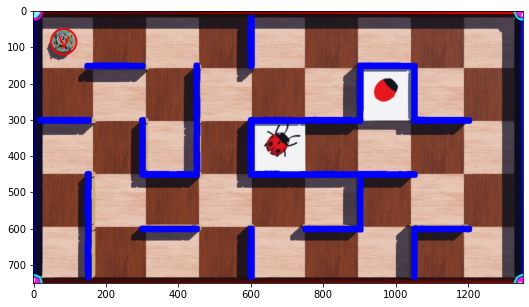

In [555]:
# Find ArUco marker centre
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
params = cv2.aruco.DetectorParameters_create()
corners, ids, _ = cv2.aruco.detectMarkers(robot_transformed, dictionary, parameters = params)
cv2.aruco.drawDetectedMarkers(robot_transformed, corners, ids)
centrex = 0
centrey = 0
for i in range(0, 4):
    centrex = centrex + corners[0][0][i][0]
    centrey = centrey + corners[0][0][i][1]
centrex = centrex/4
centrey = centrey/4

# Determine heading by comparing first corner index (orientation) to centre
if corners[0][0][0][1] > (centrey + 5):
    orientation = 'v'
elif corners[0][0][0][1] < (centrey - 5):
    orientation = '^'
elif corners[0][0][0][0] > (centrex + 5):
    orientation = '>'
elif corners[0][0][0][0] < (centrex - 5):
    orientation = '<'
    
# Draw circle and orientation on robot
new_maze_hsv = cv2.cvtColor(new_maze, cv2.COLOR_RGB2HSV)
green = cv2.inRange(new_maze_hsv, (40, 100, 0), (70, 160,180))
green = cv2.dilate(green, kernel, 3)
_,contoursg,hierarchy = cv2.findContours(green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
gx = 0
gy = 0
countg = 0
for i, g in enumerate(contoursg):
    Mg = cv2.moments(g)
    gx = gx + int(Mg['m10']/Mg['m00'])
    gy = gy + int(Mg['m01']/Mg['m00'])
    countg = countg + 1
gx = int(gx/countg)
gy = int(gy/countg)
cv2.circle(maze_transformed, (gx, gy), 35, (255, 0, 0), 3)
cv2.putText(maze_transformed, orientation, (gx-15, gy+15), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
ROBOT_COORDS = (gx, gy)
plot.figure(figsize = (9,5))
plot.imshow(maze_transformed)

## Task 6:

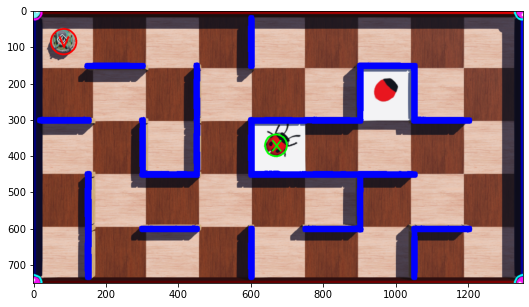

In [556]:
# Create a mask to separate out the red parts of the image (ladybugs)
new_maze_hsv = cv2.cvtColor(new_maze, cv2.COLOR_RGB2HSV)
new_maze_hsv = cv2.rectangle(new_maze_hsv, (0, 0), (1350, 20), (0,0,0), -1)
new_maze_hsv = cv2.rectangle(new_maze_hsv, (0, 730), (1350, 750), (0,0,0), -1)
bugmask = cv2.inRange(new_maze_hsv, (170, 160, 150), (180, 255, 250))
bugmask = cv2.dilate(bugmask, kernel, iterations = 2)
_,contoursb,hierarchy = cv2.findContours(bugmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
index = [0, 0]
p = 0
for i, b in enumerate(contoursb):
    if (cv2.contourArea(contoursb[i]) > 200) & (cv2.contourArea(contoursb[i]) < 2700):
        index[p] = i
        p = 1
        
# Find the areas of the red parts; the real ladybug has lesser area due to black spots
if cv2.contourArea(contoursb[index[0]]) < cv2.contourArea(contoursb[index[1]]):
    if cv2.contourArea(contoursb[index[0]]) < 400:
        Mb = cv2.moments(contoursb[index[1]])
        bx = int(Mb['m10']/Mb['m00'])
        by = int(Mb['m01']/Mb['m00'])
    else:    
        Mb = cv2.moments(contoursb[index[0]])
        bx = int(Mb['m10']/Mb['m00'])
        by = int(Mb['m01']/Mb['m00'])
else:
    Mb = cv2.moments(contoursb[index[1]])
    bx = int(Mb['m10']/Mb['m00'])
    by = int(Mb['m01']/Mb['m00'])
    
# Draw circle and x on the centroid of the area found
cv2.circle(maze_transformed, (int(bx), int(by)), 30, (0, 255, 0), 3)
cv2.putText(maze_transformed, 'x', (int(bx-15), int(by+15)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
BUG_COORDS = (int(bx), int(by))
plot.figure(figsize = (9,5))
plot.imshow(maze_transformed)

## Task 7:

In [557]:
map_built.write(' --- --- --- --- --- --- --- --- --- ')

for i in range(1, 6):
    map_built.write('\n|')
    for j in range(1, 10):
        if (ROBOT_COORDS[0] < j*150-1) & (ROBOT_COORDS[1] < i*150-1) & (ROBOT_COORDS[0] > j*150-151) & (ROBOT_COORDS[1] > i*150-151):
            map_built.write(' ' + orientation + ' ')
        elif (BUG_COORDS[0] < j*150-1) & (BUG_COORDS[1] < i*150-1) & (BUG_COORDS[0] > j*150-151) & (BUG_COORDS[1] > i*150-151):
            map_built.write(' x ')
        else:
            map_built.write('   ')
        if j == 9:
            break
        if np.all(maze_transformed[i*150-76, j*150-1] == (0, 0, 255)) | np.all(maze_transformed[i*150-76, j*150-10] == (0, 0, 255)) | np.all(maze_transformed[i*150-76, j*150 + 10] == (0, 0, 255)) :
            map_built.write('|')
        else:
            if j != 9:
                map_built.write(' ')
    map_built.write('|\n ')
    for k in range(1, 10):
        if i == 5:
            break
        if np.all(maze_transformed[i*150-1, k*150-76] == (0, 0, 255)) | np.all(maze_transformed[i*150-10, k*150-76] == (0, 0, 255)) | np.all(maze_transformed[i*150 + 10, k*150-76] == (0, 0, 255)):
                map_built.write('--- ')
        else:
            map_built.write('    ')
map_built.write('--- --- --- --- --- --- --- --- --- ')

map_built.close()